## Using MOMENT for Unsupervised Representation Learning

### 1. Introduction to Representation Learning in Epileptic Brain Activity

Representation learning is a subset of machine learning that focuses on automatically discovering meaningful features or representations from raw data. Unlike traditional approaches that rely on handcrafted features, representation learning leverages algorithms to extract patterns and structures directly from the data, enabling more robust and scalable solutions.

In the context of epileptic brain activity, representation learning plays a crucial role in analyzing complex neural signals, such as EEG or iEEG data. These signals are often high-dimensional, noisy, and non-linear, making manual feature extraction challenging. By learning representations directly from the data, models can capture subtle patterns associated with epileptic events, such as seizures or HFOs.

This approach is particularly valuable for tasks like seizure detection, localization of epileptogenic zones, and understanding the underlying mechanisms of epilepsy. Representation learning not only improves the accuracy of predictive models but also facilitates the discovery of novel biomarkers, aiding in personalized treatment strategies and advancing neuroscience research.

### 2. Load Necessary Configurations for EpiNT

In [ ]:
import torch

from yaml import CLoader as Loader
from yaml import load
from argparse import Namespace
from epint.model.EpiNTModel import EpiNT

In [2]:
def read_yaml(file):
    with open(file, 'r') as f:
        return load(f, Loader=Loader)

def merge_config(base_config, new_config):
    for key, value in new_config.items():
        base_config[key] = value
    return base_config

In [3]:
finetune_config_path = '../configs/finetune_configs.yaml'
default_config_path = '../configs/default.yaml'

finetune_config = read_yaml(finetune_config_path)
default_config = read_yaml(default_config_path)
merged_config = merge_config(default_config, finetune_config)

# convert config to arguments
args = Namespace(**merged_config)
print(merged_config)

{'patch_len': 256, 'stride_len': 256, 'sequence_len': 3072, 'dropout': 0.1, 'cls_token': True, 'downstream_dataset': '/home/ZRK/ZRK_ssd2/ZRK/Engineering_Server/Epileptogenic/dataset/downstream_wo_sfreq_equal_cpres_chn.hdf5', 'RESULTS_DIR': '/home/ZRK/sda_data/zrkdata/Epileptogenic_Results/', 'experiment_name': 'linear_probing', 'seizure_task': 'hfo_ied_detec2', 'model_name': 'EpiNT', 'patch_mask': False, 'mask_ratio': 0, 'head_dropout': 0.1, 'task': 'classification', 'd_model': 512, 'dim_feedforward': 2048, 'num_heads': 8, 'num_layers': 6, 'codebook_dim': 64, 'codebook_size': 256, 'num_quantizer': 1, 'optimizer_name': 'AdamW', 'lr_scheduler_type': 'onecyclelr', 'pct_start': 0.3, 'init_lr': 0.0001, 'three_phase': False, 'weight_decay': 0.05, 'num_workers': 4, 'max_norm': 5.0, 'max_epoch': 10, 'train_ratio': 0.7, 'train_batch_size': 1024, 'debug': True, 'seed': 666, 'run_name': '20241226_015111'}


### 3. Load EpiNT

In [4]:
"""
For the loading of EpiNT for representation learning, we only need to load the embedding from transformer.
"""

model = EpiNT(args)

# load finetune weights
finetune_weights_path = '../weights/representations.bin'
finetune_weights = torch.load(finetune_weights_path)
model.load_state_dict(finetune_weights, strict=False)
# The head and mask are not needed for representation learning

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=['embed.mask_encoding'])

### 4. Generate Data with Different Frequencies

In our paper, we use frequency domain quantizer to pre-train EpiNT, which means that EpiNT can capture frequency changes in intutive signals

In this notebook, we will make one experiment, to visualize the representations that EpiNT learns as we vary the frequency of synthetically generated sine waves.

We will use the `numpy` to generate 2048 sine waves with frequencies ranging from 1 to 40, mimicking EEG signals. 

The data generating process is: $$y = \sin(2f \pi x),$$

where the parameter $f \in [1, 40)$ controls the frequency of the simulated EEG signals.

In [5]:
import numpy as np

# Parameters
num_samples = 2048
sequence_len = args.sequence_len  # Using sequence_len from args
frequencies = np.linspace(1, 40, num_samples)

# Generate sine wave dataset
dataset = np.array([np.sin(2 * np.pi * freq * np.linspace(0, 1, sequence_len)) for freq in frequencies])
dataset = torch.tensor(dataset, dtype=torch.float32)

print(f"Generated dataset with shape: {dataset.shape}")

Generated dataset with shape: torch.Size([2048, 3072])


### 5. Extract Embeddings from Simulated Data

In [6]:
"""
The input to the model is a tensor of shape (n_samples, sequence_len).
The embedding output will be of shape (n_samples, embedding_dim).
sequence_len = 3072
embedding_dim = 512
"""

model.eval()
with torch.no_grad():
    _, cls = model(dataset)
cls = cls.cpu().numpy().squeeze(1)
print(cls.shape)

(2048, 512)


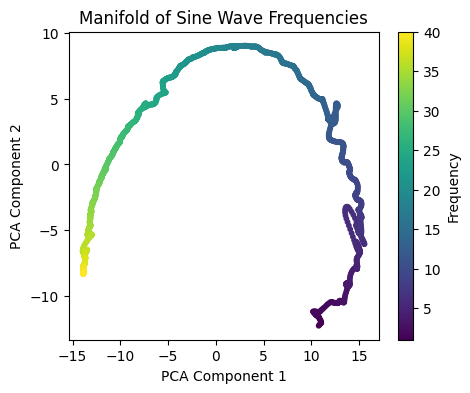

In [7]:
# plot the manifold using PCA
from sklearn.decomposition import PCA

cls_manifold = PCA(n_components=2).fit_transform(cls)

import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.scatter(cls_manifold[:, 0], cls_manifold[:, 1], c=frequencies, cmap='viridis', s=10)
plt.colorbar(label='Frequency')
plt.title('Manifold of Sine Wave Frequencies')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


### Results Interpretation

The two principal components of the representations learned by EpiNT show some structure. This suggests that EpiNT learn critical frequency features from large-scale data. Similar phenomenons can also be found in MOMENT [paper](https://arxiv.org/abs/2402.03885). 